In [1]:
%pwd
%cd /home/kwy00/ysy2/
%ls -l

/home/kwy00/ysy2
합계 625724
-rw-rw-r-- 1 kwy00 kwy00 72055804 Nov 27 21:58 copy-of-crack-segmentation-cnu.zip
drwxrwxr-x 6 kwy00 kwy00     4096 Nov 27 21:54 crackdata/
drwxrwxr-x 8 kwy00 kwy00     4096 Dec  8 14:48 guided-filter/
drwxrwxr-x 3 kwy00 kwy00     4096 Dec  6 19:10 image/
drwxrwxr-x 5 kwy00 kwy00     4096 Nov 27 22:00 kaggle_dataset/
-rw-rw-r-- 1 kwy00 kwy00 51674219 Dec 12 00:06 results.csv
-rw-rw-r-- 1 kwy00 kwy00 38967430 Dec 12 00:15 segment_model.pth_0
-rw-rw-r-- 1 kwy00 kwy00 38967430 Dec 11 23:35 segment_model.pth_10
-rw-rw-r-- 1 kwy00 kwy00 38967430 Dec 11 23:38 segment_model.pth_15
-rw-rw-r-- 1 kwy00 kwy00 38967430 Dec 11 23:42 segment_model.pth_20
-rw-rw-r-- 1 kwy00 kwy00 38967430 Dec 11 23:46 segment_model.pth_25
-rw-rw-r-- 1 kwy00 kwy00 38967430 Dec 11 23:49 segment_model.pth_30
-rw-rw-r-- 1 kwy00 kwy00 38967430 Dec 11 23:53 segment_model.pth_35
-rw-rw-r-- 1 kwy00 kwy00 38967430 Dec 11 23:57 segment_model.pth_40
-rw-rw-r-- 1 kwy00 kwy00 38967430 Dec 12 00:14 segme

In [ ]:
!pip install torchmetrics

In [ ]:
!git clone https://github.com/CHDyshli/HrSegNet4CrackSegmentation.git

In [ ]:
!pip install paddlepaddle-gpu

In [ ]:
!pip install paddleseg

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.autonotebook import tqdm

from sklearn.model_selection import train_test_split

from glob import glob
import torch
import torch.nn as nn
from torchvision import transforms as T
import albumentations as A
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
import random, gc

from albumentations.pytorch.transforms import ToTensorV2
import torch.nn.functional as F


seed=42

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"current device : {device}")

current device : cuda


In [63]:
CFG = {
    'EPOCHS' : 45,
    'LEARNING_RATE' : 1e-2,
    'NUM_CLASSES' : 1,
    'BATCH_SIZE' : 16,
    'SEED' : 42,
    'IMAGE_SIZE' : 256,
    'PATH' : os.path.join('/home/kwy00/ysy2/', 'segment_model.pth')
}

In [5]:
def init_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  np.random.seed(seed)

  random.seed(seed)

  gc.collect()
  torch.cuda.empty_cache()

init_seed(CFG['SEED'])

In [6]:
base_path = '/home/kwy00/ysy2/kaggle_dataset/'
path_to_images = os.path.join(base_path, 'train_img')
path_to_masks = os.path.join(base_path, 'train_lab')

image_paths = sorted(glob(path_to_images + '/*.jpg'))
mask_paths = sorted(glob(path_to_masks + '/*.png'))

In [7]:
test_files = pd.read_csv(os.path.join('/home/kwy00/ysy2/kaggle_dataset/', 'test_files.csv'))
test_files

,ID,label
0,11194.jpg,0
1,11270-2.jpg,0
2,11296-6.jpg,0
3,11231-9.jpg,0
4,11249-6.jpg,0
...,...,...
232,IMG_6542-7.jpg,0
233,11295.jpg,0
234,11169-2.jpg,0
235,11247-8.jpg,0


In [8]:
print("img file counts : ", len(image_paths))
print("mask file counts : ", len(mask_paths))

img file counts :  300
mask file counts :  300


In [9]:
print("test file counts : ", len(test_files))

test file counts :  237


In [10]:
train_df = pd.DataFrame({'ID' : image_paths, 'label' : mask_paths})
train_df.head(5)

,ID,label
0,/home/kwy00/ysy2/kaggle_dataset/train_img/1111...,/home/kwy00/ysy2/kaggle_dataset/train_lab/1111...
1,/home/kwy00/ysy2/kaggle_dataset/train_img/1111...,/home/kwy00/ysy2/kaggle_dataset/train_lab/1111...
2,/home/kwy00/ysy2/kaggle_dataset/train_img/1111...,/home/kwy00/ysy2/kaggle_dataset/train_lab/1111...
3,/home/kwy00/ysy2/kaggle_dataset/train_img/1111...,/home/kwy00/ysy2/kaggle_dataset/train_lab/1111...
4,/home/kwy00/ysy2/kaggle_dataset/train_img/1111...,/home/kwy00/ysy2/kaggle_dataset/train_lab/1111...


In [11]:
test_files['ID'] = base_path + '/test_img/' + test_files['ID']
test_files.head(5)

,ID,label
0,/home/kwy00/ysy2/kaggle_dataset//test_img/1119...,0
1,/home/kwy00/ysy2/kaggle_dataset//test_img/1127...,0
2,/home/kwy00/ysy2/kaggle_dataset//test_img/1129...,0
3,/home/kwy00/ysy2/kaggle_dataset//test_img/1123...,0
4,/home/kwy00/ysy2/kaggle_dataset//test_img/1124...,0


In [12]:
train, valid = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=seed)

print(f"splited train size : {len(train)}, \
 validation size: {len(valid)}, test size : {len(test_files)}")


splited train size : 270,  validation size: 30, test size : 237


In [13]:
train_transforms = A.Compose([
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2(),
], is_check_shapes=False)

test_transforms = A.Compose([
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2()
], is_check_shapes=False)

sharpening_transforms = A.Compose([
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    A.augmentations.transforms.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1.0),
    ToTensorV2()
], is_check_shapes=False)

colorjitter_transforms = A.Compose([
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    A.augmentations.transforms.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5),
                                           saturation=(0.5, 1.5), p=1.0),
    ToTensorV2(),
], is_check_shapes=False)

noise_transforms = A.Compose([
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    A.augmentations.transforms.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True,
                                          p=1.0),
    ToTensorV2()
], is_check_shapes=False)

superpixel_transforms = A.Compose([
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    A.augmentations.transforms.Superpixels(p=1.0),
    ToTensorV2()
], is_check_shapes=False)


In [14]:
rotate_transforms = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(0, 45), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)


rotate_transforms1 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(45, 90), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),    
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)


rotate_transforms2 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(90, 135), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),    
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms3 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(135, 180), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),    
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms4 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(180, 225), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),    
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms5 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(225, 270), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),    
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms6 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(315, 360), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),    
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)


rotate_transforms7 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(0, 45), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),    
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)


rotate_transforms8 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(45, 90), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),    
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)


rotate_transforms9 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(90, 135), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),    
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms10 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(135, 180), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),    
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms11 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(180, 225), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),    
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms12 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(225, 270), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),    
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms13 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(315, 360), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),    
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)


In [15]:
class CrackDataset(Dataset): # apply to image
  def __init__(self, dataset, train_mode=True, transforms=train_transforms,
               test_transforms=test_transforms):
    self.dataset = dataset.reset_index(drop=True)
    self.transforms = transforms
    self.train_mode = train_mode
    self.test_transforms = test_transforms

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    row = self.dataset.loc[idx].squeeze()

    if self.train_mode:
      image_path = row['ID']
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
      image = (image/255).astype(np.float32) # Normalize step
      transformed = self.transforms(image=image)
      image_tensor = transformed['image']

      mask_path = row['label']
      mask = cv2.imread(mask_path)
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
      mask = cv2.resize(mask, (CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']))
      _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

      mask_tensor = torch.as_tensor(mask[None], dtype=torch.float32)
      return image_tensor, mask_tensor

    else:
      image_path = row['ID']
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
      image = (image/255).astype(np.float32)
      transformed = self.test_transforms(image=image)
      image_tensor = transformed['image']

      return image_tensor

  def collate_fn(self, batch):
    images, masks = tuple(zip(*batch))
    images = [img[None] for img in images]
    masks = [msk[None] for msk in masks]
    images, masks = [torch.cat(i).to(device) for i in [images, masks]]
    return images, masks



class CrackDatasetV2(Dataset): # apply to the image and segmentation
  def __init__(self, dataset, train_mode=True, transforms=train_transforms,
               test_transforms=test_transforms):
    self.dataset = dataset.reset_index(drop=True)
    self.transforms = transforms
    self.train_mode = train_mode
    self.test_transforms=test_transforms

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    row = self.dataset.loc[idx].squeeze()

    if self.train_mode:
      image_path = row['ID']
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)

      mask_path = row['label']
      mask = cv2.imread(mask_path)
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
      # mask = cv2.resize(mask, (CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']))
      _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
      mask = mask.astype(np.uint8)

      transformed = self.transforms(image=image, mask=mask)
      image_tensor, mask_tensor = transformed['image'], transformed['mask'].unsqueeze(0)
      image_tensor = (image_tensor/255.).float()
      mask_tensor = (mask_tensor/255.).long()
     
      return image_tensor, mask_tensor

    else:
      image_path = row['ID']
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
      transformed = self.test_transforms(image=image)
      image_tensor = transformed['image']
      image_tensor = (image_tensor/255.).float()

      return image_tensor

  def collate_fn(self, batch):
    images, masks = tuple(zip(*batch))
    images = [img[None] for img in images]
    masks = [msk[None] for msk in masks]
    images, masks = [torch.cat(i).to(device) for i in [images, masks]]
    return images, masks

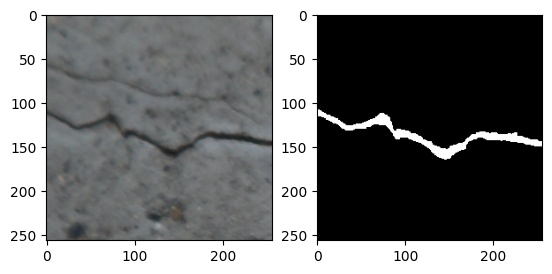

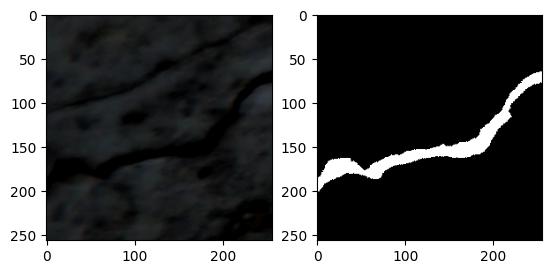

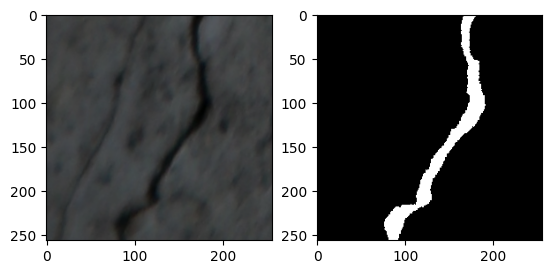

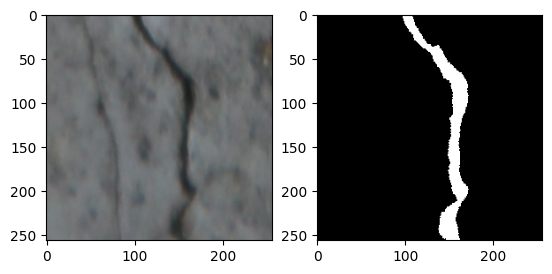

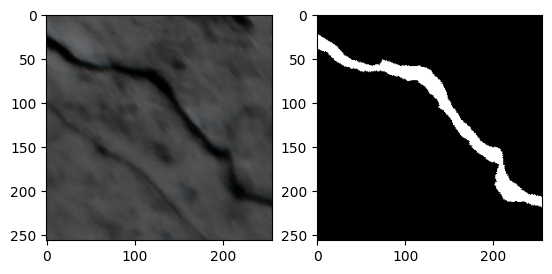

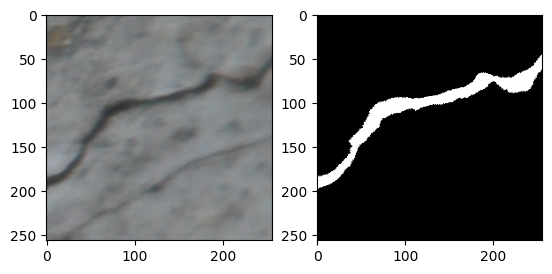

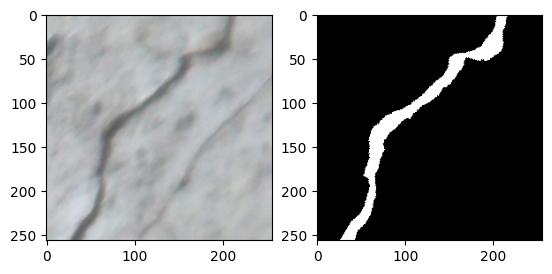

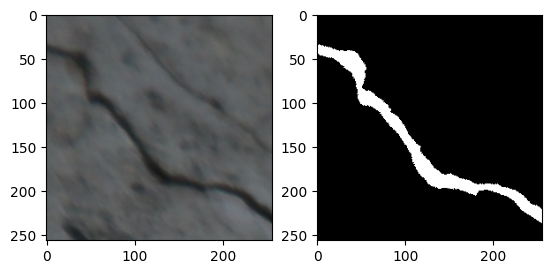

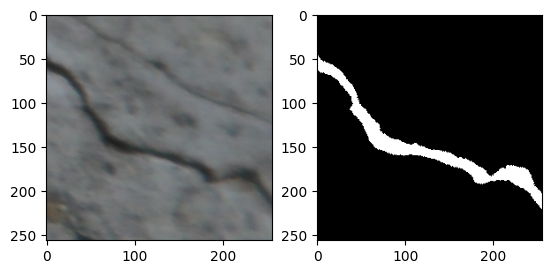

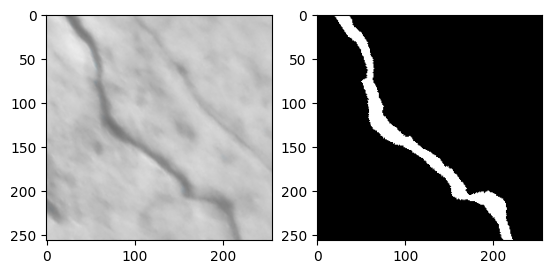

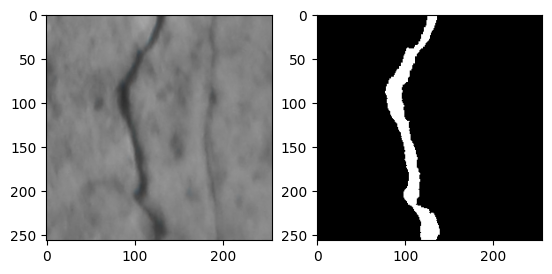

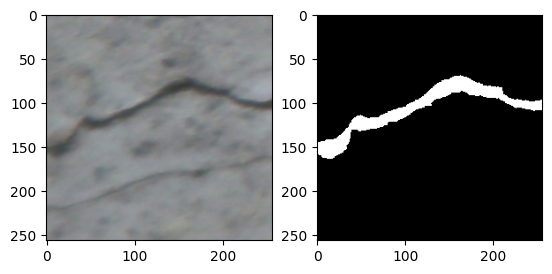

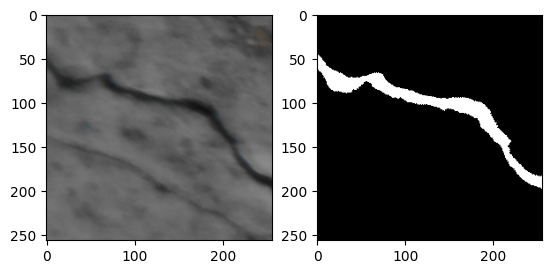

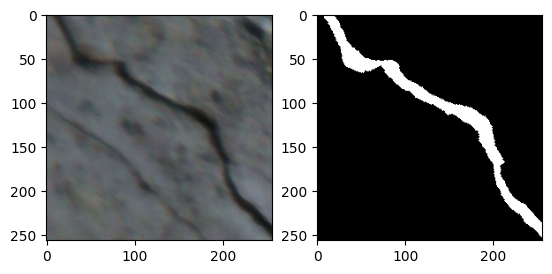

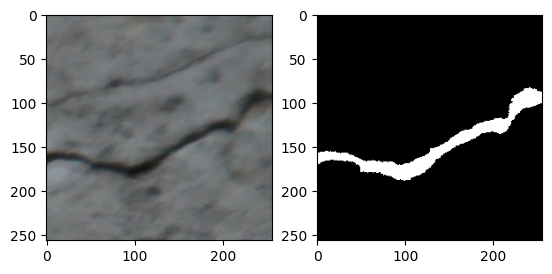

In [16]:
def drawing_tool(transforms, idx, grid):

  row = train.reset_index(drop=True).loc[idx].squeeze()
  image_path = row['ID']
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)

  
  mask_path = row['label']
  mask = cv2.imread(mask_path)
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
  mask = mask.astype(np.uint8)
  
  transformed = transforms(image=image, mask=mask)
  
  image = transformed['image']
  mask = transformed['mask'].unsqueeze(0)
  
  # image = (image/255).float()
  # mask = mask.float()
  
  # print(np.unique(image.cpu().detach().numpy()))
  # print(np.unique(mask.cpu().detach().numpy()))

  plt.subplot(121)
  plt.imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
  plt.subplot(122)
  plt.imshow(mask.cpu().detach().numpy().transpose(1, 2, 0), cmap='gray')
  plt.show()

img_num = 20
drawing_tool(train_transforms, img_num, 143)
drawing_tool(rotate_transforms, img_num, 1551)
drawing_tool(rotate_transforms1, img_num, 1551)
drawing_tool(rotate_transforms2, img_num, 1551)
drawing_tool(rotate_transforms3, img_num, 1551)
drawing_tool(rotate_transforms4, img_num, 1551)
drawing_tool(rotate_transforms5, img_num, 1551)
drawing_tool(rotate_transforms6, img_num, 1551)
drawing_tool(rotate_transforms7, img_num, 1551)
drawing_tool(rotate_transforms8, img_num, 1551)
drawing_tool(rotate_transforms9, img_num, 1551)
drawing_tool(rotate_transforms10, img_num, 1551)
drawing_tool(rotate_transforms11, img_num, 1551)
drawing_tool(rotate_transforms12, img_num, 1551)
drawing_tool(rotate_transforms13, img_num, 1551)

# drawing_tool(noise_transforms, img_num, 141)
# drawing_tool(colorjitter_transforms, img_num, 142)
# drawing_tool(superpixel_transforms, img_num, 144)
# drawing_tool(sharpening_transforms, img_num, 1)


In [17]:
# train_dataset = CrackDataset(train)
train_dataset = CrackDatasetV2(train)
rotate_dataset = CrackDatasetV2(train, transforms=rotate_transforms)
rotate_dataset1 = CrackDatasetV2(train, transforms=rotate_transforms1)
rotate_dataset2 = CrackDatasetV2(train, transforms=rotate_transforms2)
rotate_dataset3 = CrackDatasetV2(train, transforms=rotate_transforms3)
rotate_dataset4 = CrackDatasetV2(train, transforms=rotate_transforms4)
rotate_dataset5 = CrackDatasetV2(train, transforms=rotate_transforms5)
rotate_dataset6 = CrackDatasetV2(train, transforms=rotate_transforms6)
rotate_dataset7 = CrackDatasetV2(train, transforms=rotate_transforms7)
rotate_dataset8 = CrackDatasetV2(train, transforms=rotate_transforms8)
rotate_dataset9 = CrackDatasetV2(train, transforms=rotate_transforms9)
rotate_dataset10 = CrackDatasetV2(train, transforms=rotate_transforms10)
rotate_dataset11 = CrackDatasetV2(train, transforms=rotate_transforms11)
rotate_dataset12 = CrackDatasetV2(train, transforms=rotate_transforms12)
rotate_dataset13 = CrackDatasetV2(train, transforms=rotate_transforms13)

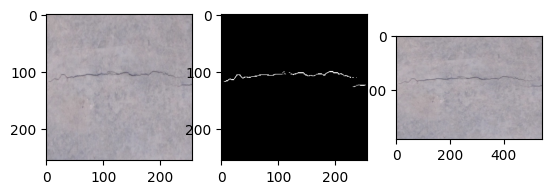

In [18]:
idx = 30

plt.subplot(131)
plt.imshow(train_dataset[idx][0].cpu().detach().numpy().transpose(1, 2, 0))

plt.subplot(132)
plt.imshow(train_dataset[idx][1].cpu().detach().numpy().transpose(1, 2, 0), cmap='gray')

plt.subplot(133)
row = train.reset_index(drop=True).loc[idx].squeeze()
image_path = row['ID']
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
plt.imshow(image)

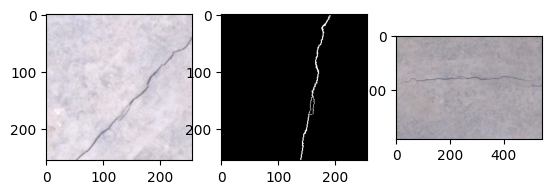

In [19]:
plt.subplot(131)
plt.imshow(rotate_dataset9[idx][0].cpu().detach().numpy().transpose(1, 2, 0))

plt.subplot(132)
plt.imshow(rotate_dataset9[idx][1].cpu().detach().numpy().transpose(1, 2, 0), cmap='gray')

plt.subplot(133)
plt.imshow(image)

In [20]:
# train_dataset = CrackDataset(train)
# colorjitter_dataset = CrackDatasetV2(train, transforms=colorjitter_transforms)
# noise_dataset = CrackDatasetV2(train, transforms=noise_transforms)
# superpixel_dataset = CrackDatasetV2(train, transforms=superpixel_transforms)
# sharpening_dataset = CrackDatasetV2(train, transforms=sharpening_transforms)

valid_dataset = CrackDatasetV2(valid)
test_dataset = CrackDataset(test_files, train_mode=False)

total_dataset = ConcatDataset([train_dataset,rotate_dataset,rotate_dataset1,
                               rotate_dataset2,rotate_dataset3,rotate_dataset4,
                               rotate_dataset5,rotate_dataset6,rotate_dataset7,
                               rotate_dataset8,rotate_dataset9,rotate_dataset10,
                               rotate_dataset11,rotate_dataset12,rotate_dataset13])

train_dataloader = DataLoader(total_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True,
                              collate_fn = train_dataset.collate_fn, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False,
                              collate_fn=valid_dataset.collate_fn, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)

In [21]:
@torch.no_grad()
def validate_test_image(model, dataset):
  idx = np.random.randint(len(dataset))
  dataset = dataset.reset_index(drop=True)
  row = dataset.loc[idx].squeeze()

  image = cv2.imread(row['ID'])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
  image = (image/255).astype(np.float32)
  image_tensor = train_transforms(image=image)['image'].unsqueeze(0).to(device)

  mask = cv2.imread(row['label'])
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  mask = cv2.resize(mask, (CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']))
  _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

  model.eval()
  output = model(image_tensor)
  output = output[0].cpu().detach().numpy().transpose(1, 2, 0)
  
  # output shape -> (batch_size, channel=2, height, width)
  # output = output.cpu().detach().numpy()
  output = np.where(output[:, :, 0] < output[:, : ,1], 1, 0)
  # output = np.expand_dims(output, axis=1)
  
  

  plt.figure(figsize=(8, 4))
  plt.subplot(131)
  plt.title('Original image')
  plt.imshow(image)

  plt.subplot(132)
  plt.title('Original mask')
  plt.imshow(mask, cmap='gray')

  plt.subplot(133)
  plt.title('Predicted mask')
  plt.imshow(output, cmap='gray')

  plt.tight_layout()
  plt.show()
  plt.pause(0.001)


In [64]:
import math
import torch.nn.functional as F

class HrSegNetB64(nn.Module):
    """
    Args:
        num_classes (int): The unique number of target classes.

        in_channels (int, optional): The channels of input image. Default: 3.

        base (int, optional): The base channel number of the model. Default: 48.
    """
    def __init__(self,
                 in_channels=3, # input channel
                 base=64, # base channel of the model,
                 num_classes=2, # number of classes
                 pretrained=None
                 ):
        super(HrSegNetB64, self).__init__()
        self.base = base
        self.num_classed = num_classes
        self.pretrained = pretrained
        # Stage 1 and 2 constitute the stem of the model, which is mainly used to extract low-level features.
        # Meanwhile, stage1 and 2 reduce the input image to 1/2 and 1/4 of the original size respectively
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=base // 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base // 2),
            nn.ReLU(),
        )
        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=base // 2, out_channels=base, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base),
            nn.ReLU(),
        )

        self.seg1 = SegBlock(base=base, stage_index=1)
        self.seg2 = SegBlock(base=base, stage_index=2)
        self.seg3 = SegBlock(base=base, stage_index=3)

        self.aux_head1 = SegHead(inplanes=base, interplanes=base, outplanes=num_classes, aux_head=True)
        self.aux_head2 = SegHead(inplanes=base, interplanes=base, outplanes=num_classes, aux_head=True)
        self.head = SegHead(inplanes=base, interplanes=base, outplanes=num_classes)

        self.init_weight()
        self.classifier = nn.Softmax2d()


    def forward(self, x):
        logit_list = []
        h, w = x.shape[2], x.shape[3]
        # aux_head only used in training
        if self.training:
            stem1_out = self.stage1(x)
            stem2_out = self.stage2(stem1_out)
            hrseg1_out = self.seg1(stem2_out)
            hrseg2_out = self.seg2(hrseg1_out)
            hrseg3_out = self.seg3(hrseg2_out)
            last_out = self.head(hrseg3_out)
            seghead1_out = self.aux_head1(hrseg1_out)
            seghead2_out = self.aux_head2(hrseg2_out)
            logit_list = [last_out, seghead1_out, seghead2_out]
            logit_list = [F.interpolate(logit, size=(h, w), mode='bilinear', align_corners=True) for logit in logit_list]
            logit_list = [self.classifier(logit) for logit in logit_list]
            
            return (logit_list[0], logit_list[1], logit_list[2])
        else:
            stem1_out = self.stage1(x)
            stem2_out = self.stage2(stem1_out)
            hrseg1_out = self.seg1(stem2_out)
            hrseg2_out = self.seg2(hrseg1_out)
            hrseg3_out = self.seg3(hrseg2_out)
            last_out = self.head(hrseg3_out)
            logit_list = [last_out]
            logit_list = [F.interpolate(logit, size=(h, w), mode='bilinear', align_corners=True) for logit in logit_list]
            logit_list = [self.classifier(logit) for logit in logit_list]
            
            return logit_list[0]

    # we does not use pretrained model on other crack dataset
    def init_weight(self):
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
          torch.nn.init.kaiming_normal_(m.weight)
        elif isinstance(m, nn.BatchNorm2d):
          torch.nn.init.constant_(m.weight, 1)
          torch.nn.init.constant_(m.bias, 0)



class SegBlock(nn.Module):
    def __init__(self,
                 base=32,
                 stage_index=1):# stage_index=1,2,3.
        super(SegBlock, self).__init__()

        #  Convolutional layer for high-resolution paths with constant spatial resolution and constant channel
        self.h_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=base, out_channels=base, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base),
            nn.ReLU()
        )
        self.h_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=base, out_channels=base, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base),
            nn.ReLU()
        )
        self.h_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=base, out_channels=base, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base),
            nn.ReLU()
        )

        # sematic guidance path/low-resolution path
        if stage_index==1: #first stage, stride=2, spatial resolution/2, channel*2
            self.l_conv1 = nn.Sequential(
                nn.Conv2d(in_channels=base, out_channels=base*int(math.pow(2, stage_index)), kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(base*int(math.pow(2, stage_index))),
                nn.ReLU()
            )
        elif stage_index==2: #second stage
            self.l_conv1 = nn.Sequential(
                nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
                nn.Conv2d(in_channels=base, out_channels=base*int(math.pow(2, stage_index)), kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(base*int(math.pow(2, stage_index))),
                nn.ReLU()
            )
        elif stage_index==3:
            self.l_conv1 = nn.Sequential(
                nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
                nn.Conv2d(in_channels=base, out_channels=base*int(math.pow(2, stage_index)), kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(base*int(math.pow(2, stage_index))),
                nn.ReLU(),
                nn.Conv2d(in_channels=base*int(math.pow(2, stage_index)), out_channels=base*int(math.pow(2, stage_index)), kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(base*int(math.pow(2, stage_index))),
                nn.ReLU()
            )
        else:
            raise ValueError("stage_index must be 1, 2 or 3")
        self.l_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=base*int(math.pow(2, stage_index)), out_channels=base*int(math.pow(2, stage_index)), kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base*int(math.pow(2, stage_index))),
            nn.ReLU()
        )
        self.l_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=base*int(math.pow(2, stage_index)), out_channels=base*int(math.pow(2, stage_index)), kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base*int(math.pow(2, stage_index))),
            nn.ReLU()
        )

        self.l2h_conv1 = nn.Conv2d(in_channels=base*int(math.pow(2, stage_index)), out_channels=base, kernel_size=1, stride=1, padding=0)
        self.l2h_conv2 = nn.Conv2d(in_channels=base*int(math.pow(2, stage_index)), out_channels=base, kernel_size=1, stride=1, padding=0)
        self.l2h_conv3 = nn.Conv2d(in_channels=base*int(math.pow(2, stage_index)), out_channels=base, kernel_size=1, stride=1, padding=0)



    def forward(self, x):
        # out = []
        # out.append(self.h_conv3(self.h_conv2(self.h_conv1(x))))
        # out.append(self.l_conv3(self.l_conv2(self.l_conv1(x))))
        size = x.shape[2:]
        out_h1 = self.h_conv1(x) # high resolution path
        out_l1 = self.l_conv1(x) # low resolution path
        # print(out_l1.shape)
        out_l1_i = F.interpolate(out_l1, size=size, mode='bilinear', align_corners=True) # upsample
        out_hl1 = self.l2h_conv1(out_l1_i) + out_h1 # low to high

        out_h2 = self.h_conv2(out_hl1)
        out_l2 = self.l_conv2(out_l1)
        # print(out_l2.shape)
        out_l2_i = F.interpolate(out_l2, size=size, mode='bilinear', align_corners=True)
        out_hl2 = self.l2h_conv2(out_l2_i) + out_h2

        out_h3 = self.h_conv3(out_hl2)
        out_l3 = self.l_conv3(out_l2)
        # print(out_l3.shape)
        out_l3_i = F.interpolate(out_l3, size=size, mode='bilinear', align_corners=True)
        out_hl3 = self.l2h_conv3(out_l3_i) + out_h3
        return out_hl3

# seg head
class SegHead(nn.Module):
    def __init__(self, inplanes, interplanes, outplanes, aux_head=False):
        super(SegHead, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU()
        if aux_head:
            self.con_bn_relu = nn.Sequential(
                nn.Conv2d(in_channels=inplanes, out_channels=interplanes, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(interplanes),
                nn.ReLU(),
            )
        else:
            self.con_bn_relu = nn.Sequential(
                nn.ConvTranspose2d(in_channels=inplanes, out_channels=interplanes, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(interplanes),
                nn.ReLU(),
            )
        self.conv = nn.Conv2d(in_channels=interplanes, out_channels=outplanes, kernel_size=1, stride=1, padding=0)


    def forward(self, x):
        x = self.bn1(x)
        x = self.relu(x)
        x = self.con_bn_relu(x)
        out = self.conv(x)
        return out


def get_model():
  model = HrSegNetB64()
  return model.to(device)


model = get_model()

In [58]:
class EarlyStopping:
  def __init__(self, patience=5, min_delta=0, path=CFG['PATH']):
    self.path = path
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_loss = np.inf
    self.early_stop = False

  def __call__(self, val_loss, model=None):
    if self.best_loss - val_loss > self.min_delta:
      torch.save(model.state_dict(), self.path)
      print(f'Model saved to : {self.path}')
      self.best_loss = val_loss
      self.counter = 0
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
      if self.counter >= self.patience:
        print('INFO: Early stopping')
        self.early_stop = True


In [59]:
class OHEMLoss(nn.Module):
    
    def __init__(self, ratio=0.5, weight=None, label_smoothing=0.0):
        super(OHEMLoss, self).__init__()
        
        self.ratio = ratio
        self.weight = weight
        self.label_smoothing = label_smoothing
    
    def forward(self, cls_pred, cls_target):
                
        # (batch_size, channels, height, width), channels=2
        ohem_cls_loss = F.cross_entropy(cls_pred, cls_target, 
                                        weight=self.weight,
                                        label_smoothing=self.label_smoothing,
                                        reduction='none', ignore_index=-1)
        # (batch_size, height, width)
        ohem_cls_loss = ohem_cls_loss.view(-1)
        
        # (batch_size * height * width)
        sorted_ohem_loss, idx = torch.sort(ohem_cls_loss, descending=True)
        
        keep_num = int(sorted_ohem_loss.size()[0] * self.ratio) # ratio <= 1.0
        
        if keep_num < sorted_ohem_loss.size()[0]:
            keep_idx_cuda = idx[:keep_num]
            ohem_cls_loss = ohem_cls_loss[keep_idx_cuda]
            
        cls_loss = ohem_cls_loss.sum() / keep_num
        
        return cls_loss
    
# class OHEMLoss(nn.Module):
    
#     def __init__(self, ratio=0.3, weight=None, label_smoothing=0.0):
#         super(OHEMLoss, self).__init__()
        
#         self.ratio = ratio
#         self.weight = weight
#         self.label_smoothing = label_smoothing
    
#     def forward(self, cls_pred, mask):
        
#         batch_size = cls_pred.shape[0]

#         pos_idcs = mask>=0.5 # crack region
#         neg_idcs = mask<0.5 # non-crack region
        
#         # neg_pred = cls_pred[:, 0, :, :].unsqueeze(1)
#         # pos_pred = cls_pred[:, 1, :, :].unsqueeze(1)
        
#         neg_pred = cls_pred[:, 0, :, :]
#         pos_pred = cls_pred[:, 1, :, :]
        
#         pos_output_0 = pos_pred[pos_idcs]
#         pos_output_1 = pos_pred[pos_idcs]
        
#         # (channel, (pos_pixels * batch_size))
#         pos_output = torch.stack((pos_output_0, pos_output_1))
#         pos_mask = mask[pos_idcs]
        
#         neg_output_0 = neg_pred[neg_idcs] # channel 0
#         neg_output_1 = neg_pred[neg_idcs] # channel 1
        
#         # (channels, (neg_pixels * batch_size))
#         neg_output = torch.stack((neg_output_0, neg_output_1))
#         neg_mask = mask[neg_idcs]
        
#         total_negative = neg_output.size()[1]
        
#         pos_loss = F.cross_entropy(pos_output, pos_mask, reduction='mean')
        
#         neg_loss = F.cross_entropy(neg_output, neg_mask, reduction='none')
#         sorted_neg_loss, idx = torch.sort(neg_loss, descending=True)
        
#         sampled_negative = max(int(self.ratio * total_negative), 1)
#         if sampled_negative < total_negative: # self.ratio != 1 and < 1
#             neg_loss = neg_loss[idx[:sampled_negative]]
        
#         hard_neg_loss = neg_loss.mean()
#         loss = (pos_loss + hard_neg_loss)/2
#         return loss
    
# from torch.autograd import Variable

# class OHEMLoss(nn.Module):
    
#     def __init__(self, top_k=0.3, weight=None, label_smoothing=0.0):
#         super(OHEMLoss, self).__init__()
        
#         self.loss = nn.NLLLoss()
#         self.ratio = top_k
#         self.weight = weight
#         self.label_smoothing = label_smoothing
    
#     def forward(self, input, taget):
#         loss = Variable(torch.Tensor(1).zero_())
#         for idx, row in enumerate(input):
#             gt = target[idx]
#             pred = torch.unsqueeze(row, 0)
#             cost = self.loss(pred, gt)
#             loss = torch.cat((loss, cost), 0)
#         loss = loss[1:]
#         if self.k == 1:
#             valid_loss = loss
#         index = torch.topk(loss, int(self.top_k * loss.size()[0]))
#         valid_loss = loss[index[1]]
                
#         return torch.mean(valid_loss)

In [60]:
# criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([0.1, 3.0].to(device)), label_smoothing=0.2)
# criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([0.4, 0.6]).to(device))
criterion = OHEMLoss(ratio=0.1, weight=None, 
                     label_smoothing=0.0)


optimizer = torch.optim.SGD(model.parameters(), lr=CFG['LEARNING_RATE'], momentum=0.9, weight_decay=0.0005)
# optimizer = torch.optim.AdamW(model.parameters(), lr=CFG['LEARNING_RATE'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, min_lr=1e-6, factor=0.1)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, power=0.9, total_iters=CFG['EPOCHS'])

early=EarlyStopping()

In [61]:
def train_one_batch(batch, model, criterion, optimizer):
  images, masks = batch
  optimizer.zero_grad()
  output = model(images)
  masks = masks.squeeze(1)
  loss1 = criterion(output[0], masks)
  loss2 = criterion(output[1], masks)
  loss3 = criterion(output[2], masks)
  loss = loss1+loss2+loss3
  
  loss.backward()
  optimizer.step()

  return loss.item()

@torch.no_grad()
def validate_one_batch(batch, model, criterion):
  images, masks = batch
  output = model(images)
  loss = criterion(output, masks)
  return loss.item()

def validate_one_batch(batch, model):
  images, masks = batch
  output = model(images)
  loss = criterion(output, masks)
  return loss.item()

Epoch 1/45
current_lr :  0.00879157901936799


  0%|          | 0/253 [00:00<?, ?it/s]

Train loss: 3.3197.


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.1001.
--------------------------------------------------


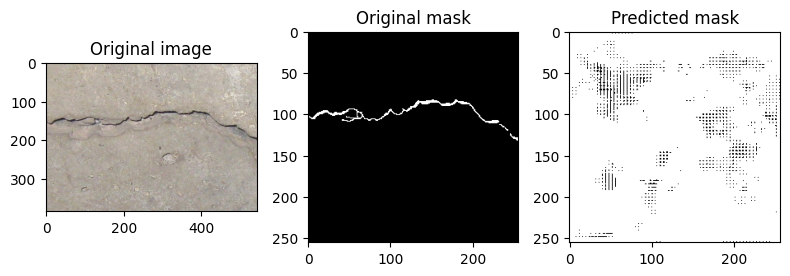

Val F1 Score: 0.06706149896075315
Val Precision: 0.9213093606385552
Val Recall: 0.034797181388720275
Epoch 2/45
current_lr :  0.01


  0%|          | 0/253 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [65]:
train_losses, valid_losses = [], []
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

for epoch in range(CFG['EPOCHS']):

  print(f'Epoch {epoch+1}/{CFG["EPOCHS"]}')
  print('current_lr : ', optimizer.param_groups[0]['lr'])
  epoch_train_losses, epoch_valid_losses = [], []

  model.train()
  for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
    batch_train_loss = train_one_batch(batch, model, criterion, optimizer)
    epoch_train_losses.append(batch_train_loss)

  epoch_train_loss = np.array(epoch_train_losses).mean()
  train_losses.append(epoch_train_loss)

  print(f"Train loss: {epoch_train_loss:.4f}.")

  model.eval()
  y_true, y_pred = [], []

  for i, batch in enumerate(tqdm(valid_dataloader, leave=False)):
    images, masks = batch
    output = model(images)
    masks = masks.squeeze(1)
    batch_valid_loss = criterion(output, masks)
    epoch_valid_losses.append(batch_valid_loss.item())
    
    # output shape -> (batch_size, channel=2, height, width)
    output = output.detach().cpu().numpy()
    output = np.where(output[:, 0, :, :] < output[:,1,:,:], 1, 0)
    output = np.expand_dims(output, axis=1)

    y_true.append(masks.cpu().numpy())
    # y_pred.append(output.cpu().detach().numpy())
    y_pred.append(output)

  epoch_valid_loss = np.array(epoch_valid_losses).mean()
  valid_losses.append(epoch_valid_loss)
  print(f'Valid loss: {epoch_valid_loss:.4f}.')
  print('-'*50)

  y_true = np.concatenate(y_true, axis=0)
  y_pred = np.concatenate(y_pred, axis=0)
  # y_pred = np.where(y_pred > 127, 255, 0)

  y_true = y_true.reshape(-1)
  y_pred = y_pred.reshape(-1)

  validate_test_image(model, valid)
  
  print('Val F1 Score:', f1_score(y_pred, y_true))
  print('Val Precision:', precision_score(y_pred, y_true))
  print('Val Recall:', recall_score(y_pred, y_true))

  if (epoch%5 == 0):
    torch.save(model.state_dict(), CFG['PATH']+f'_{epoch}')

  scheduler.step(epoch)
  # early(epoch_valid_loss, model =model)
  # if early.early_stop:
  #   print(f"Validation loss did not improve for {early.patience} epochs. Training stopped.")
  #   model.load_state_dict(torch.load(CFG['PATH']))
  #   break


In [181]:
y_pred = []
my_submission = pd.read_csv(os.path.join(base_path, 'test_files.csv'))

model.eval()
for path, images in tqdm(zip(my_submission['ID'], test_dataloader), total=len(test_dataloader)):
  output = model(images.to(device)).cpu().detach().numpy()
  
  output = np.where(output[:, 0, :, :] < output[:,1,:,:], 1, 0)
  output = np.expand_dims(output, axis=1)
  
  output = np.where(output.astype(np.float32) > 0.5, 1, 0)
  output = output[0][0].reshape(-1, )
  
  img = list(map(int, output.tolist()))
  label = "".join(map(str, img))

  chunk_size = 8
  chunks = [label[i:i+chunk_size] for i in range(0, len(label), chunk_size)]

  for i in range(len(chunks)):
    y_pred.append([path+str(i), "2" + chunks[i]])


  0%|          | 0/237 [00:00<?, ?it/s]

In [183]:
y_pred = []

epoch = 30
test_model = get_model()
test_model.load_state_dict(torch.load(CFG['PATH']+f'_{epoch}'))

my_submission = pd.read_csv(os.path.join(base_path, 'test_files.csv'))
test_model.eval()

for path, images in tqdm(zip(my_submission['ID'], test_dataloader), total=len(test_dataloader)):
  output = test_model(images.to(device)).cpu().detach().numpy()
  
  output = np.where(output[:, 0, :, :] < output[:,1,:,:], 1, 0)
  output = np.expand_dims(output, axis=1)

  output = np.where(output.astype(np.float32) > 0.5, 1, 0)
  output = output[0][0].reshape(-1, )
  
  img = list(map(int, output.tolist()))
  label = "".join(map(str, img))

  chunk_size = 8
  chunks = [label[i:i+chunk_size] for i in range(0, len(label), chunk_size)]

  for i in range(len(chunks)):
    y_pred.append([path+str(i), "2" + chunks[i]])


  0%|          | 0/237 [00:00<?, ?it/s]

In [184]:
submission = pd.DataFrame(y_pred, columns=['ID', 'label'])
submission['label'] = submission['label'].astype(int)
submission.to_csv('./results.csv', index=False)